In [1]:
import numpy as np
import pandas as pd
# Import visualization libraries
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import seaborn as sns
import os
from astropy import units as u
from astropy.coordinates import SkyCoord
import traceback
from dataclasses import make_dataclass
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ybsc_catalog = None
with open('bsc5.dat', 'r') as fi:
    ybsc_catalog = fi.readlines()
ybsc_catalog[0]
print(len(ybsc_catalog))
YBSC_Entry = make_dataclass("YBSC_Entry", [
    ("id", int),
    ("name", str),
    ("constellation", str),
    ("coord", SkyCoord),
    ("glon", float),
    ("glat", float),
    ("gal_coord", SkyCoord),
    ("Vmag", float),
    ("n_Vmag", str),
    ("u_Vmag", str),
    ("spectral_type", str),
    ("spectral_type_full", str),
    ("n_spectral_type", str),
    ("RI", float),
    ("n_RI", str),
    ("BV", float),
    ("u_BV", str),
    ("UB", float),
    ("u_UB", str),
    ("RadVel", float),
    ("RotVel", float),
    ("Parallax", float),
    ("n_Parallax", str),
    ("group", str)
])

# TODO: YBSC also has some other entries for spectral types, should understand what they are
spectral_types = ["O", "B", "A", "F", "G", "K", "M", "D", "S", "C", "W"]

def parse_float(n):
    try:
        return float(n)
    except ValueError:
        return None

def parse_int(n):
    try:
        return int(n)
    except ValueError:
        return None

def parse_str(n):
    try:
        return str(n)
    except ValueError:
        return None

    
entries = []
for i, row in enumerate(ybsc_catalog):
    try:
        star_id = parse_int(row[0:4])
        name = row[4:14]
        constellation = row[11:14].strip()

        coord_str = f"{row[75:77]} {row[77:79]} {row[79:83]} {row[83]}{row[84:86]} {row[86:88]} {row[88:90]}"
        # print(coord_str)
        coord = SkyCoord(coord_str, unit=(u.hourangle, u.deg), frame='icrs')
        
        glon = parse_float(row[90:96])
        glat = parse_float(row[96:102])
        gal_coord = SkyCoord(l=glon, b=glat, frame='galactic', unit=u.degree)

        mag = parse_float(row[102:107])
        n_mag = row[107]
        u_mag = row[108]

        spectral_type_full = row[127:147].strip()
        spectral_type = spectral_type_full[0]
        n_spectral_type = row[147]
        
        if not np.isin(spectral_type, spectral_types):
            # For cases like gG8
            spectral_type = spectral_type_full[1]
            if not np.isin(spectral_type, spectral_types):
                continue
        
        # UBV system
        BV = parse_float(row[109:114])
        u_BV = row[114]
        
        UB = parse_float(row[115:120])
        u_UB = row[120]
        
        RI = parse_float(row[121:126])
        n_RI = row[126]
        
        RadVel = parse_int(row[166:170])
        RotVel = parse_int(row[176:179])
        
        n_parallax = row[160]
        parallax = parse_float(row[161:166])

        group = parse_float(row[205:208])

    
        entries.append(YBSC_Entry(
            id=star_id,
            name=name,
            constellation=constellation,
            coord=coord,
            glon=glon,
            glat=glat,
            gal_coord=gal_coord,
            Vmag=mag,
            n_Vmag=n_mag,
            u_Vmag=u_mag,
            spectral_type=spectral_type,
            spectral_type_full=spectral_type_full,
            n_spectral_type=n_spectral_type,
            BV=BV,
            u_BV=u_BV,
            UB=UB,
            u_UB=u_UB,
            RI=RI,
            n_RI=n_RI,
            RadVel=RadVel,
            RotVel=RotVel,
            Parallax=parallax,
            n_Parallax=n_parallax,
            group = group
        ))
    except ValueError as e:
#         print(traceback.format_exc())
        print(f"Skipping row {i+1} Reason: {e}")
df = pd.DataFrame(entries)
#df['group'].unique()

9110
Skipping row 92 Reason: Cannot parse first argument data "                    " for attribute ra
Skipping row 95 Reason: Cannot parse first argument data "                    " for attribute ra
Skipping row 182 Reason: Cannot parse first argument data "                    " for attribute ra
Skipping row 1057 Reason: Cannot parse first argument data "                    " for attribute ra
Skipping row 1841 Reason: Cannot parse first argument data "                    " for attribute ra
Skipping row 2472 Reason: Cannot parse first argument data "                    " for attribute ra
Skipping row 2496 Reason: Cannot parse first argument data "                    " for attribute ra
Skipping row 3515 Reason: Cannot parse first argument data "                    " for attribute ra
Skipping row 3671 Reason: Cannot parse first argument data "                    " for attribute ra
Skipping row 6309 Reason: Cannot parse first argument data "                    " for attribute ra
Skipping r

In [37]:
df['cartesian'] = df['coord'].apply(lambda c: c.cartesian.xyz.value if c is not None else None)

pleiads_ids = []
with open('ybsc5.notes', 'r') as fi:
    ybsc_notes = fi.readlines()

for row in ybsc_notes:
    if row[7:13][0] == 'G' and 'Mel 22' in row:
        pleiads_ids.append(int(row[0:5]))

# Create a cluster column and initialize it with None
df['cluster'] = None

# Set 'cluster' to 'Mel25' for rows with ids in hyades_ids
df.loc[df['id'].isin(pleiads_ids), 'cluster'] = 'Mel25'

hyades = df[df['id'].isin(pleiads_ids)]

# Optional: Print the IDs for verification
print(pleiads_ids)

[1103, 1140, 1142, 1144, 1145, 1149, 1151, 1152, 1156, 1165, 1172, 1178, 1180, 1183, 1185]


In [38]:
hyades_ids = []

with open('ybsc5.notes', 'r') as fi:
    ybsc_notes = fi.readlines()

for row in ybsc_notes:
    if row[7:13][0] == 'G' and 'Mel 25' in row:
        hyades_ids.append(int(row[0:5]))


# Set 'cluster' to 'Mel25' for rows with ids in hyades_ids
df.loc[df['id'].isin(hyades_ids), 'cluster'] = 'Mel25'

hyades = df[df['id'].isin(hyades_ids)]

# Optional: Print the IDs for verification
print(hyades_ids)

[656, 1201, 1233, 1238, 1254, 1279, 1292, 1319, 1331, 1346, 1351, 1354, 1356, 1358, 1368, 1373, 1376, 1380, 1385, 1387, 1388, 1389, 1391, 1392, 1394, 1403, 1408, 1409, 1411, 1412, 1414, 1422, 1427, 1428, 1430, 1432, 1436, 1444, 1459, 1472, 1473, 1479, 1480, 1507, 1517, 1519, 1547, 1566, 1620, 1670, 1672, 1905, 2124]


In [39]:
df["coord_ra_deg"] = df["coord"].transform(lambda c: c.ra.degree)
df["coord_dec_deg"] = df["coord"].transform(lambda c: c.dec.degree)

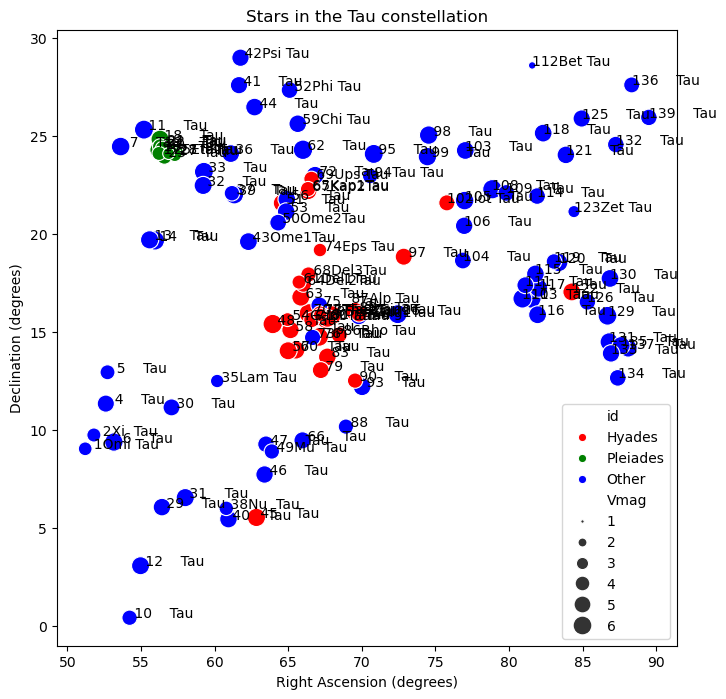

In [40]:


# Filter and sort the constellation data as before
constellation_to_view = "Tau"
constellation = df[df["constellation"] == constellation_to_view].sort_values(by="Vmag", ascending=False)

plt.figure(figsize=(8, 8))

def plotlabel(xvar, yvar, label):
    ax.text(xvar + 0.002, yvar + 0.002, label)

ax = plt.subplot(111)

# Map colors based on whether the point's ID is in hyades_ids
def get_color(star_id):
    if star_id in hyades_ids:
        return 'Hyades'
    elif star_id in pleiads_ids:
        return 'Pleiades'
    else:
        return 'Other'
colors = constellation['id'].apply(get_color)

sns.scatterplot(
    ax=ax,
    data=constellation,
    x="coord_ra_deg",
    y="coord_dec_deg",
    hue=colors,  # Use colors for differentiation
    palette={"Hyades": "red", "Other": "blue", "Pleiades": "green"},
    size="Vmag",
    sizes=(1, 200),
    legend=True  # Turn off legend if not needed
)

constellation.apply(lambda x: plotlabel(x['coord_ra_deg'], x['coord_dec_deg'], x['name']), axis=1)

plt.title(f"Stars in the {constellation_to_view} constellation")
plt.xlabel("Right Ascension (degrees)")
plt.ylabel("Declination (degrees)")
plt.show()


In [24]:
df["cartesian"]

0       [0.7040940672212915, 0.01587054794165058, 0.70...
1       [0.9997174261645215, 0.022090310757975136, -0....
2       [0.9947729755573012, 0.023160836124704105, -0....
3       [0.9724907543038803, 0.024191749243191826, 0.2...
4       [0.5232450652342131, 0.014310913828500579, 0.8...
                              ...                        
9080    [0.2940204150164801, 0.0057887923885929235, -0...
9081    [0.8223562934866133, 0.01757292393537612, 0.56...
9082    [0.3182815115026543, 0.006511902007362263, -0....
9083    [0.8935647913527808, 0.019237603533938833, 0.4...
9084    [0.4798876053992105, 0.010687660112490002, 0.8...
Name: cartesian, Length: 9085, dtype: object

In [29]:
# Extract max and min values for each coordinate in 'cartesian'
pleiads_max = np.max(np.array(pleiads['cartesian'].tolist()), axis=0)
pleiads_min = np.min(np.array(pleiads['cartesian'].tolist()), axis=0)

# Filter df using the computed bounds
filtered_df = df[df['cartesian'].apply(lambda x: np.all(pleiads_min <= x) and np.all(x <= pleiads_max))]

# Display the filtered DataFrame
excluded_ids = filtered_df[~filtered_df['id'].isin(pleiads_ids)]['id']

# Display the IDs
print(excluded_ids)

1130    1137
Name: id, dtype: int64


In [ ]:
# Extract max and min values for each coordinate in 'cartesian'
hyades_max = np.max(np.array(hyades['cartesian'].tolist()), axis=0)
hyades_min = np.min(np.array(hyades['cartesian'].tolist()), axis=0)

# Filter df using the computed bounds
filtered_df = df[df['cartesian'].apply(lambda x: np.all(hyades_min <= x) and np.all(x <= hyades_max))]

excluded_ids = filtered_df[~filtered_df['id'].isin(hyades_ids)]['id']

# Display the IDs
print(excluded_ids)

705      711
717      723
722      728
723      729
758      764
        ... 
2067    2076
2075    2084
2090    2099
2102    2111
2107    2116
Name: id, Length: 259, dtype: int64
